# Handwritten Digit Generation using Naive Bayes Algorithm

Naive Bayes algorithms can be used as generative models. This code demonstrates new handwritten digit generation using the Naive Bayes algorithm.

**Dataset**: MNIST handwritten digit dataset

## Import Required Libraries

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB
from tensorflow.keras.datasets import mnist
from scipy import ndimage

print("Libraries imported successfully!")

Libraries imported successfully!


## Load the MNIST Dataset

Load the MNIST dataset from Keras. Since the problem is to generate new samples (not predict class labels), we focus on the training data.

In [60]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print('Original X_train shape:', train_X.shape)
print('Y_train shape:', train_y.shape)
print('Unique classes:', np.unique(train_y))

Original X_train shape: (60000, 28, 28)
Y_train shape: (60000,)
Unique classes: [0 1 2 3 4 5 6 7 8 9]


## Data Preprocessing

Flatten each image so that rather than a 28x28 array, it becomes a 1x784 array.

In [61]:
# Flatten the images
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1] * train_X.shape[2])
print('Flattened X_train shape:', train_X.shape)
print('Single image shape:', train_X[0].shape)

Flattened X_train shape: (60000, 784)
Single image shape: (784,)


## Normalize and Convert to Binary

Divide each pixel value by 255 to normalize to [0,1], then convert to binary [0,1] for Bernoulli Naive Bayes.

In [62]:
# Normalize pixel values to 0-1 range
train_X = train_X / 255.0

# Convert to binary (0 or 1) for Bernoulli Naive Bayes
# Pixels > 0.5 become 1, others become 0
train_X_binary = (train_X > 0.5).astype(int)

print('Data normalized and converted to binary')
print('Unique values in binary data:', np.unique(train_X_binary))

Data normalized and converted to binary
Unique values in binary data: [0 1]


## Visualize Sample Data

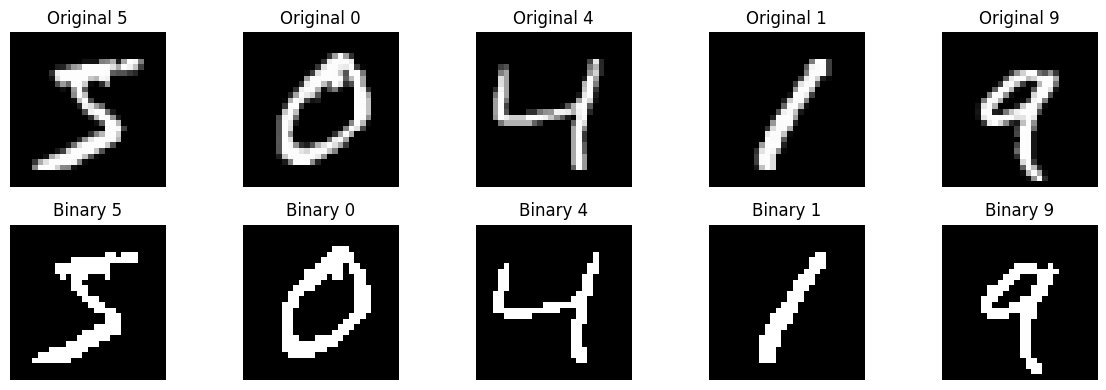

In [63]:
# Display some sample images
plt.figure(figsize=(12, 4))
for i in range(5):
    # Original image
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_X[i].reshape(28, 28), cmap='gray')
    plt.title(f'Original {train_y[i]}')
    plt.axis('off')
    
    # Binary version
    plt.subplot(2, 5, i + 6)
    plt.imshow(train_X_binary[i].reshape(28, 28), cmap='gray')
    plt.title(f'Binary {train_y[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Train Bernoulli Naive Bayes Model

In [64]:
print("Training Bernoulli Naive Bayes model...")

# Create and train the model
model = BernoulliNB()
model.fit(train_X_binary, train_y)

print("Model trained successfully!")
print(f"Number of classes: {len(model.classes_)}")
print(f"Classes: {model.classes_}")

Training Bernoulli Naive Bayes model...
Model trained successfully!
Number of classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]


## Understanding the Model: Probability Extraction

The model learns probabilities for each pixel to be 'on' (value 1) for each digit class. We can extract these probabilities using `feature_log_prob_` and convert back to probabilities using `np.exp()`.

In [65]:
# Extract probabilities for digit '0' (class 0)
prob_digit_0 = np.exp(model.feature_log_prob_[0])

print(f"Probability shape for digit 0: {prob_digit_0.shape}")
print(f"Min probability: {prob_digit_0.min():.4f}")
print(f"Max probability: {prob_digit_0.max():.4f}")
print(f"Mean probability: {prob_digit_0.mean():.4f}")

Probability shape for digit 0: (784,)
Min probability: 0.0002
Max probability: 0.8123
Mean probability: 0.1756


## Visualize Learned Probability Distributions

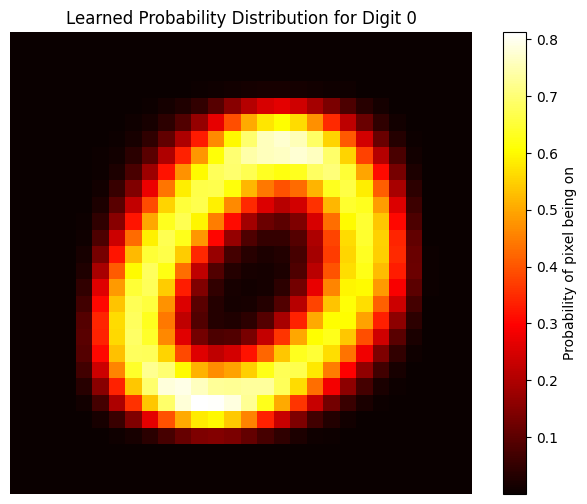

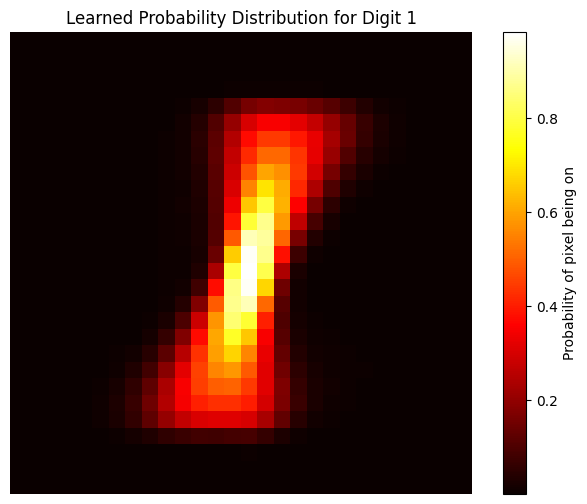

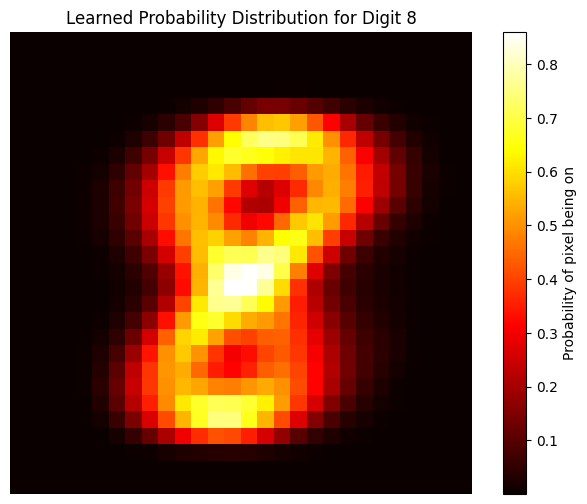

In [66]:
def show_probability_heatmap(digit_class):
    """Show the learned probability distribution for a digit class"""
    prob_pixels = np.exp(model.feature_log_prob_[digit_class])
    prob_image = prob_pixels.reshape(28, 28)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(prob_image, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Probability of pixel being on')
    plt.title(f'Learned Probability Distribution for Digit {digit_class}')
    plt.axis('off')
    plt.show()

# Show probability heatmaps for digits 0, 1, and 8
for digit in [0, 1, 8]:
    show_probability_heatmap(digit)

## Digit Generation Functions

Generate new digit images using different methods: template, threshold, and probabilistic sampling.

In [67]:
def remove_noise(image, min_size=2):
    """Remove small isolated pixel groups (noise reduction)"""
    labeled, num_features = ndimage.label(image)
    sizes = ndimage.sum(image, labeled, range(num_features + 1))
    mask = sizes >= min_size
    clean_image = mask[labeled]
    return clean_image.astype(int)

def generate_digit_template(digit_class, threshold=0.3):
    """Generate digit using template method (fixed threshold)"""
    prob_pixels = np.exp(model.feature_log_prob_[digit_class])
    gen_image = (prob_pixels > threshold).astype(int)
    return gen_image.reshape(28, 28)

def generate_digit_threshold(digit_class, percentile=70):
    """Generate digit using adaptive threshold method"""
    prob_pixels = np.exp(model.feature_log_prob_[digit_class])
    threshold = np.percentile(prob_pixels, percentile)
    gen_image = (prob_pixels > threshold).astype(int)
    gen_image_2d = gen_image.reshape(28, 28)
    return remove_noise(gen_image_2d)

def generate_digit_probabilistic(digit_class, temperature=1.0):
    """Generate digit using probabilistic sampling with temperature control"""
    prob_pixels = np.exp(model.feature_log_prob_[digit_class])
    
    # Apply temperature scaling
    if temperature != 1.0:
        prob_pixels = prob_pixels ** (1.0 / temperature)
        prob_pixels = prob_pixels / prob_pixels.max()  # Normalize
    
    # Probabilistic sampling
    random_vals = np.random.rand(784)
    gen_image = (random_vals < prob_pixels).astype(int)
    gen_image_2d = gen_image.reshape(28, 28)
    
    # Apply noise reduction
    return remove_noise(gen_image_2d)

def generate_digit(digit_class, method='probabilistic', **kwargs):
    """Main generation function that calls appropriate method"""
    if method == 'template':
        return generate_digit_template(digit_class, **kwargs)
    elif method == 'threshold':
        return generate_digit_threshold(digit_class, **kwargs)
    elif method == 'probabilistic':
        return generate_digit_probabilistic(digit_class, **kwargs)
    else:
        raise ValueError(f"Unknown method: {method}")

print("Generation functions defined successfully!")

Generation functions defined successfully!


## Test Different Generation Methods

Testing different generation methods:
template: shape (28, 28), values [0 1]
threshold: shape (28, 28), values [0 1]
probabilistic: shape (28, 28), values [0 1]


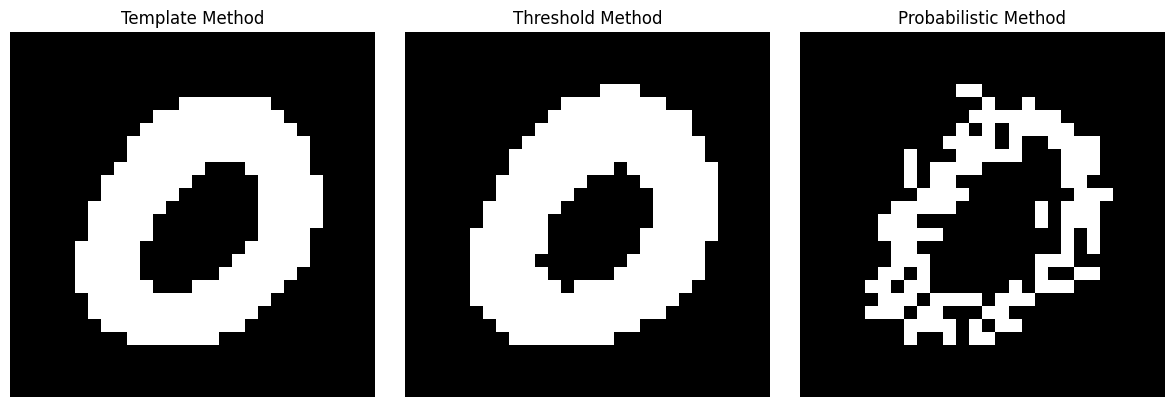

In [68]:
# Test different generation methods
print("Testing different generation methods:")
plt.figure(figsize=(12, 4))

methods = ['template', 'threshold', 'probabilistic']
for i, method in enumerate(methods):
    test_generated = generate_digit(0, method=method)
    plt.subplot(1, 3, i + 1)
    plt.imshow(test_generated, cmap='gray')
    plt.title(f'{method.capitalize()} Method')
    plt.axis('off')
    print(f"{method}: shape {test_generated.shape}, values {np.unique(test_generated)}")

plt.tight_layout()
plt.show()

## Compare Actual vs Generated Digits

Comparing actual vs generated digits:

Digit 0:


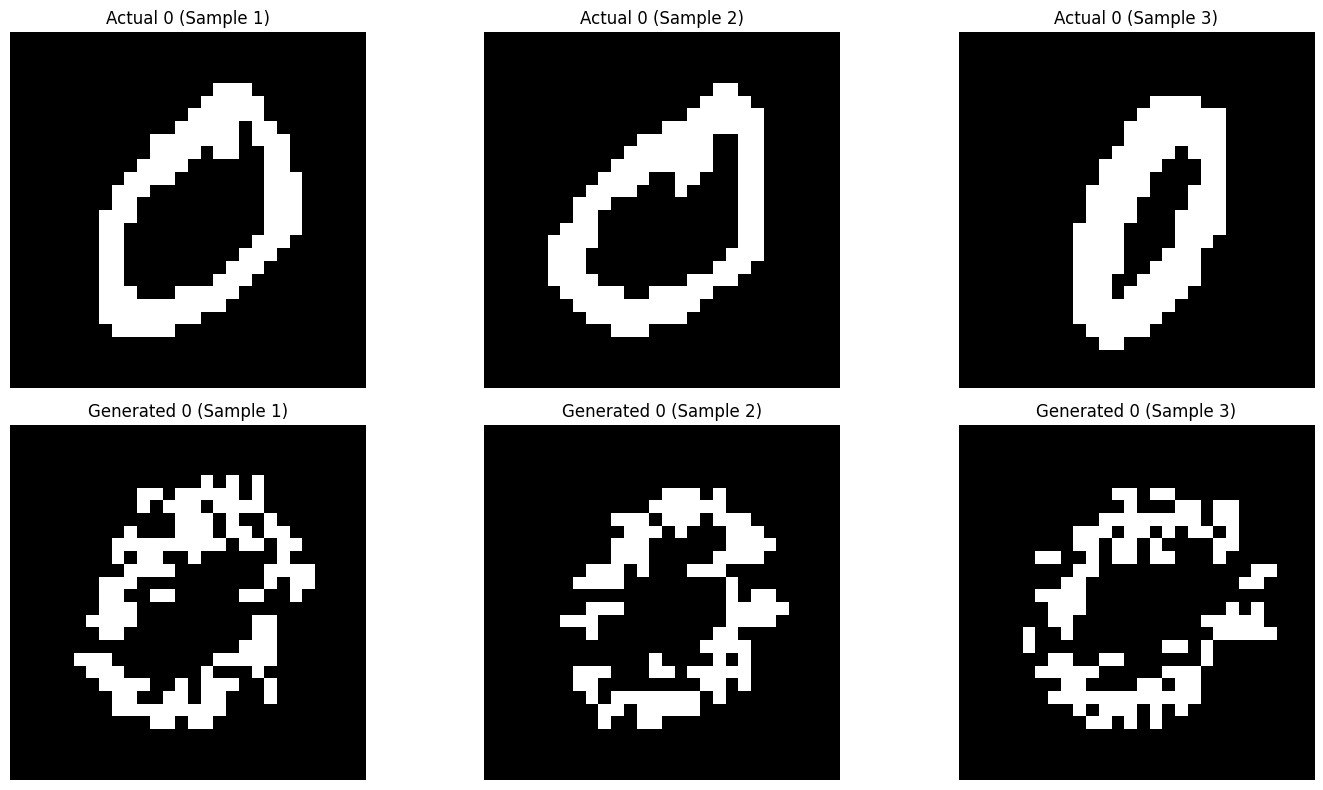


Digit 1:


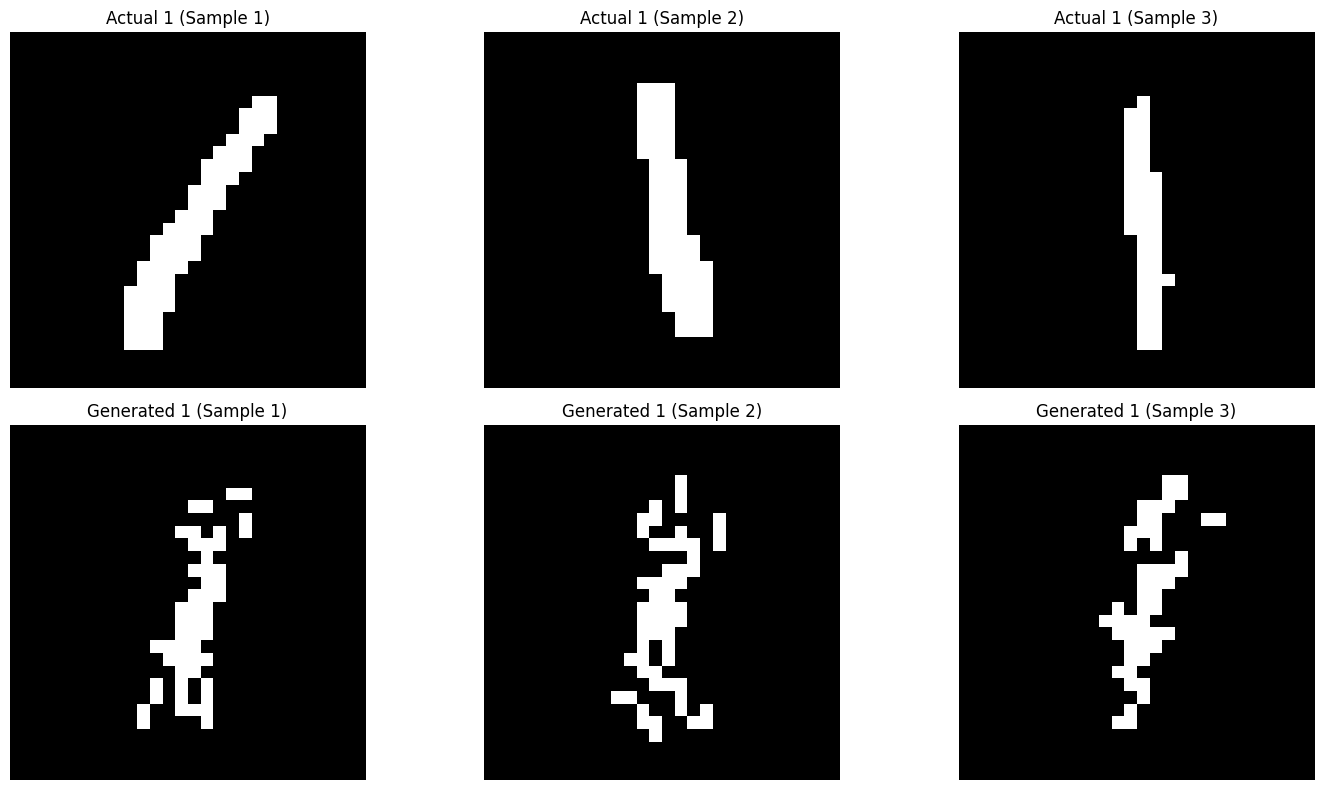


Digit 8:


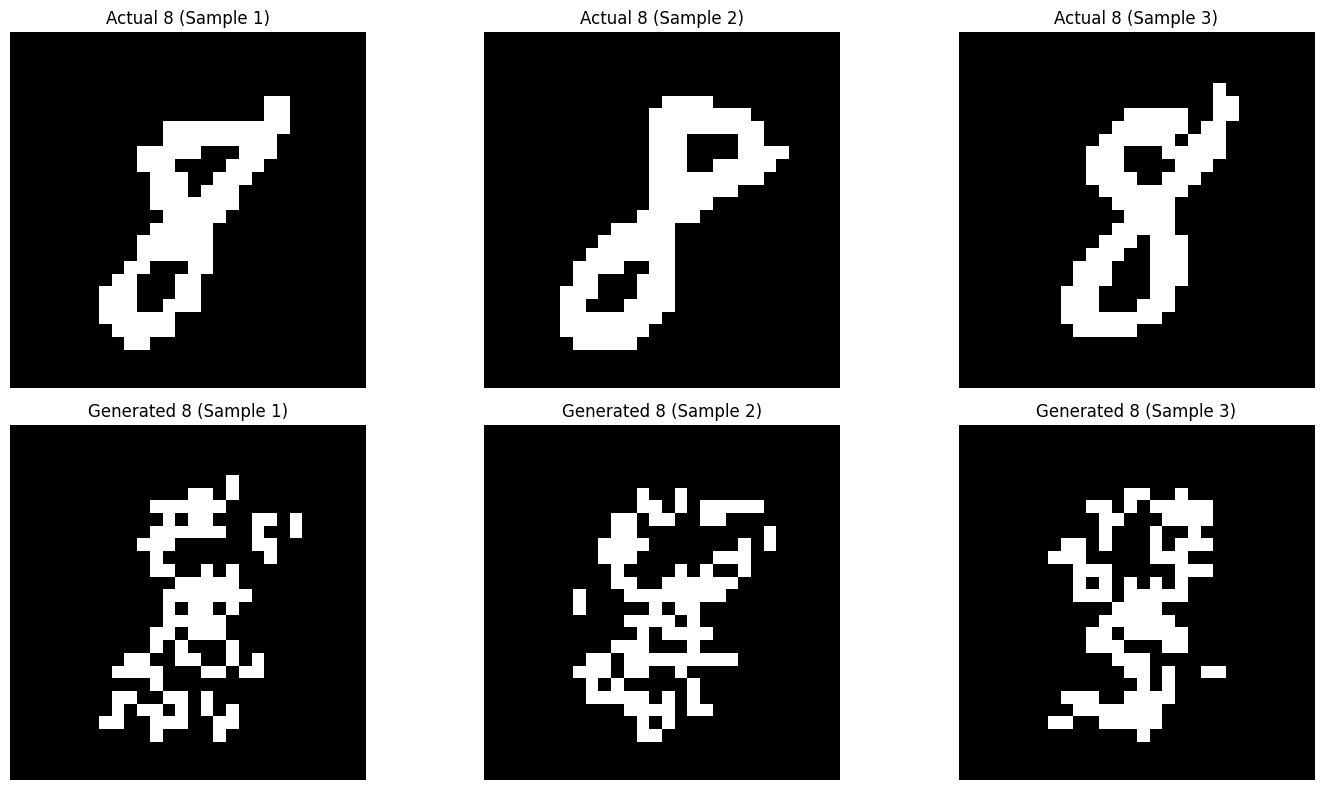

In [69]:
def plot_comparison(digit_class, num_examples=3):
    """Plot comparison between actual and generated digits"""
    # Find actual examples of the digit
    actual_indices = np.where(train_y == digit_class)[0][:num_examples]
    
    plt.figure(figsize=(15, 8))
    
    for i in range(num_examples):
        # Plot actual image
        plt.subplot(2, num_examples, i + 1)
        actual_img = train_X_binary[actual_indices[i]].reshape(28, 28)
        plt.imshow(actual_img, cmap='gray')
        plt.title(f'Actual {digit_class} (Sample {i+1})', fontsize=12)
        plt.axis('off')
        
        # Plot generated image
        plt.subplot(2, num_examples, i + num_examples + 1)
        gen_img = generate_digit(digit_class, method='probabilistic')
        plt.imshow(gen_img, cmap='gray')
        plt.title(f'Generated {digit_class} (Sample {i+1})', fontsize=12)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Generate and display examples for different digits
print("Comparing actual vs generated digits:")
for digit in [0, 1, 8]:
    print(f"\nDigit {digit}:")
    plot_comparison(digit, num_examples=3)

## Generate All Digits (0-9)

Generating one example of each digit (0-9) using different methods:


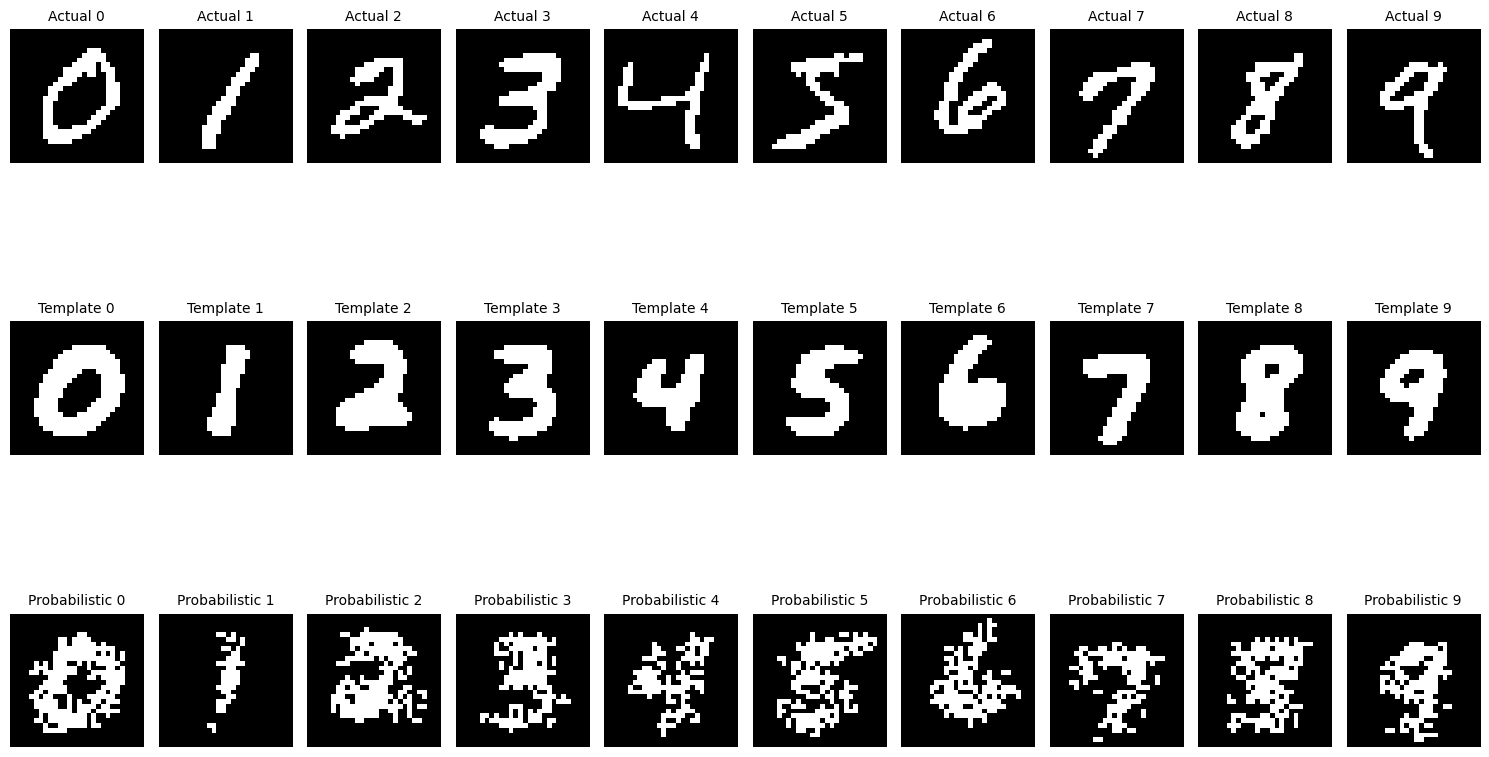

In [70]:
# Generate a grid of all digits using different methods
print("Generating one example of each digit (0-9) using different methods:")
plt.figure(figsize=(15, 10))

for digit in range(10):
    # Actual digit
    plt.subplot(3, 10, digit + 1)
    actual_idx = np.where(train_y == digit)[0][0]
    actual_img = train_X_binary[actual_idx].reshape(28, 28)
    plt.imshow(actual_img, cmap='gray')
    plt.title(f'Actual {digit}', fontsize=10)
    plt.axis('off')
    
    # Generated digit - template method
    plt.subplot(3, 10, digit + 11)
    gen_img = generate_digit(digit, method='template')
    plt.imshow(gen_img, cmap='gray')
    plt.title(f'Template {digit}', fontsize=10)
    plt.axis('off')
    
    # Generated digit - probabilistic method
    plt.subplot(3, 10, digit + 21)
    gen_img = generate_digit(digit, method='probabilistic', temperature=1.5)
    plt.imshow(gen_img, cmap='gray')
    plt.title(f'Probabilistic {digit}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Generate Multiple Samples of Same Digit

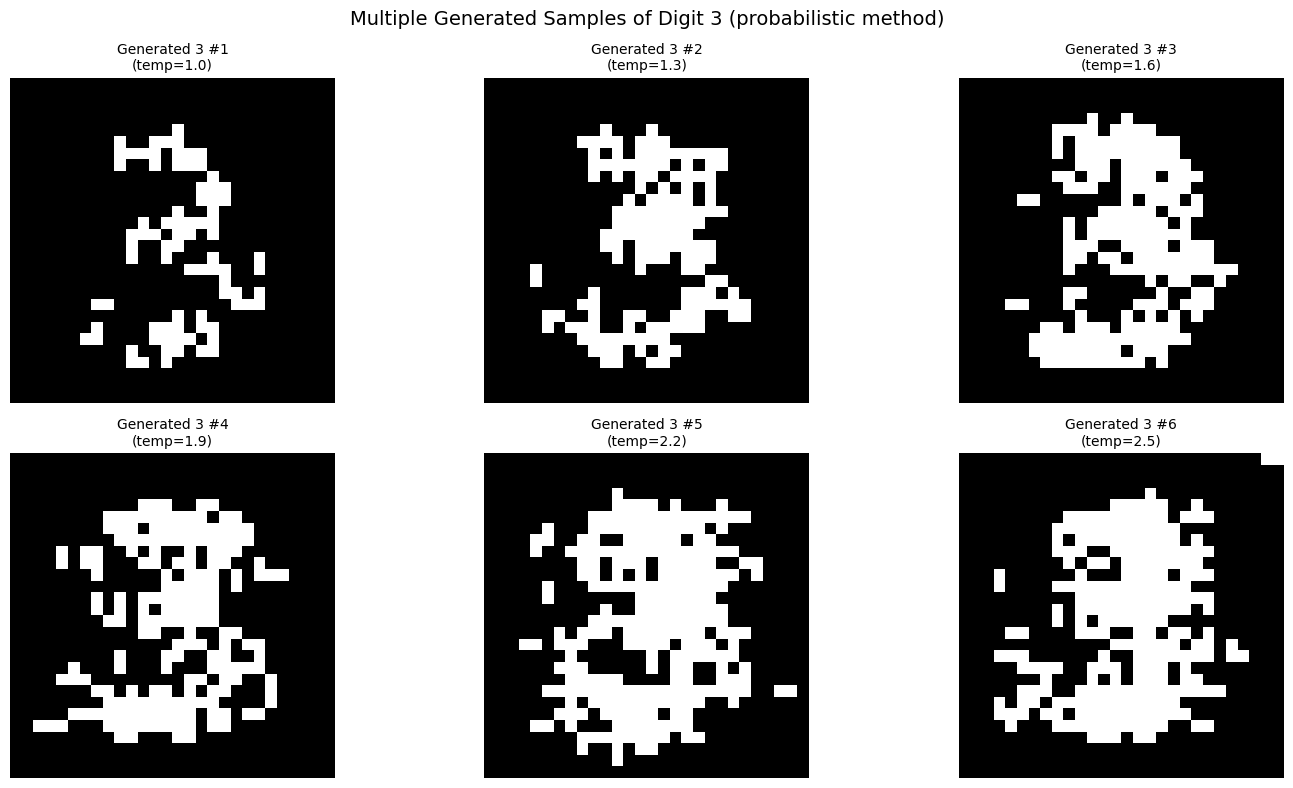

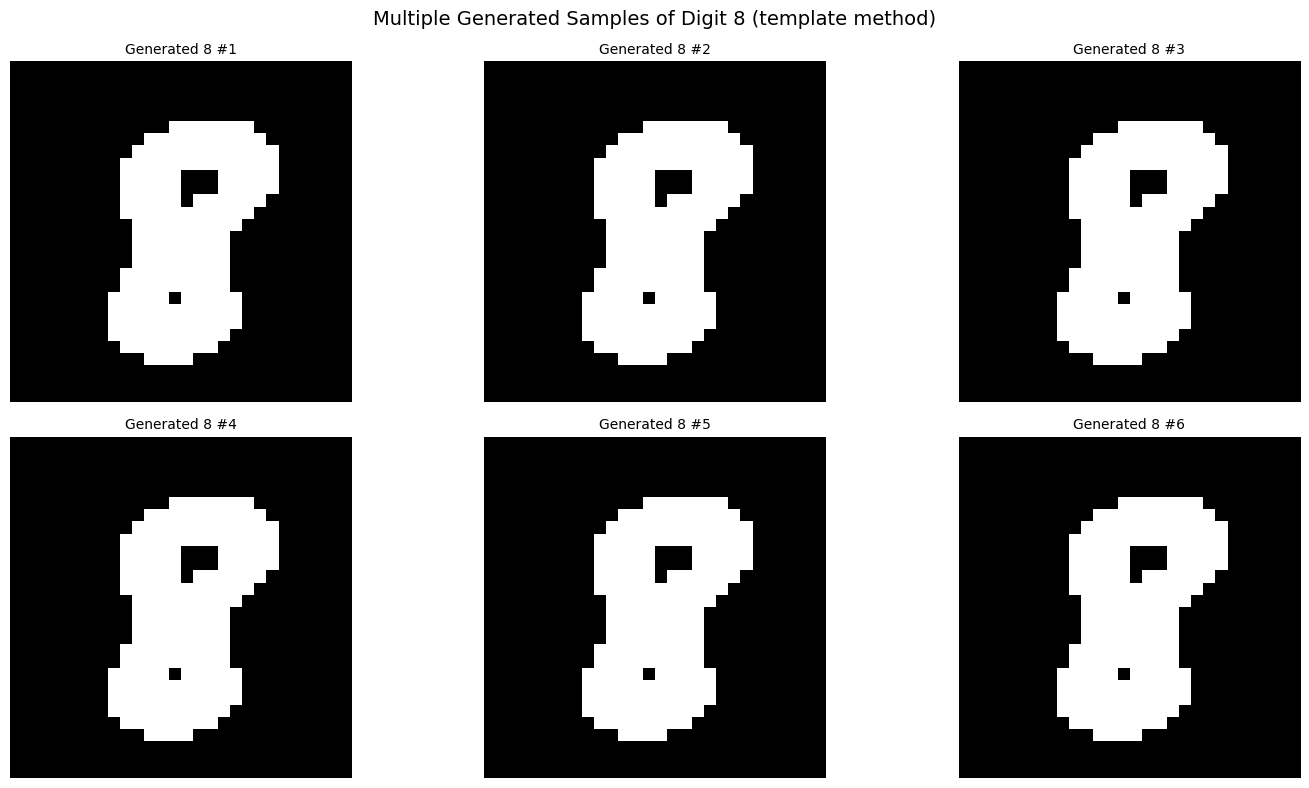

In [71]:
def generate_multiple_samples(digit_class, num_samples=6, method='probabilistic'):
    """Generate multiple samples of the same digit"""
    plt.figure(figsize=(15, 8))
    
    for i in range(num_samples):
        plt.subplot(2, num_samples//2, i + 1)
        # Use different temperatures for variety
        if method == 'probabilistic':
            temp = 1.0 + (i * 0.3)  # Varying temperature from 1.0 to 2.5
            gen_img = generate_digit(digit_class, method=method, temperature=temp)
            title_suffix = f'\n(temp={temp:.1f})'
        else:
            gen_img = generate_digit(digit_class, method=method)
            title_suffix = ''
        
        plt.imshow(gen_img, cmap='gray')
        plt.title(f'Generated {digit_class} #{i+1}{title_suffix}', fontsize=10)
        plt.axis('off')
    
    plt.suptitle(f'Multiple Generated Samples of Digit {digit_class} ({method} method)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Generate multiple samples for digit 3 and 8
generate_multiple_samples(3, num_samples=6, method='probabilistic')
generate_multiple_samples(8, num_samples=6, method='template')

## Analysis and Insights

In [72]:
# Analyze the model's learned probabilities
print("Analysis of Learned Probabilities:")
print("=" * 40)

for digit in range(10):
    prob_pixels = np.exp(model.feature_log_prob_[digit])
    print(f"Digit {digit}:")
    print(f"  Average pixel probability: {prob_pixels.mean():.4f}")
    print(f"  Std deviation: {prob_pixels.std():.4f}")
    print(f"  Pixels with prob > 0.8: {(prob_pixels > 0.8).sum()}")
    print(f"  Pixels with prob < 0.2: {(prob_pixels < 0.2).sum()}")
    print()

print("\n" + "="*50)
print("SUMMARY AND IMPROVEMENTS:")
print("="*50)
print("The improved Naive Bayes digit generator uses three methods:")
print("\n1. TEMPLATE METHOD:")
print("   - Uses pixels with probability > 0.3 as a template")
print("   - Produces clean, recognizable digits")
print("   - Best for clear, readable output")
print("\n2. THRESHOLD METHOD:")
print("   - Uses adaptive threshold (70th percentile)")
print("   - Accounts for digit-specific characteristics")
print("   - Balances clarity and variation")
print("\n3. PROBABILISTIC METHOD:")
print("   - Uses temperature-controlled sampling")
print("   - Includes noise reduction (removes isolated pixels)")
print("   - Provides natural variation while maintaining structure")
print("\nKey improvements over original:")
print("- Better probability interpretation")
print("- Noise reduction post-processing")
print("- Multiple generation strategies")
print("- Temperature control for variation")
print("- Adaptive thresholding per digit class")

Analysis of Learned Probabilities:
Digit 0:
  Average pixel probability: 0.1756
  Std deviation: 0.2448
  Pixels with prob > 0.8: 2
  Pixels with prob < 0.2: 533

Digit 1:
  Average pixel probability: 0.0769
  Std deviation: 0.1803
  Pixels with prob > 0.8: 12
  Pixels with prob < 0.2: 677

Digit 2:
  Average pixel probability: 0.1509
  Std deviation: 0.2079
  Pixels with prob > 0.8: 0
  Pixels with prob < 0.2: 556

Digit 3:
  Average pixel probability: 0.1436
  Std deviation: 0.2145
  Pixels with prob > 0.8: 1
  Pixels with prob < 0.2: 577

Digit 4:
  Average pixel probability: 0.1225
  Std deviation: 0.1947
  Pixels with prob > 0.8: 5
  Pixels with prob < 0.2: 604

Digit 5:
  Average pixel probability: 0.1304
  Std deviation: 0.1810
  Pixels with prob > 0.8: 0
  Pixels with prob < 0.2: 566

Digit 6:
  Average pixel probability: 0.1393
  Std deviation: 0.2152
  Pixels with prob > 0.8: 6
  Pixels with prob < 0.2: 580

Digit 7:
  Average pixel probability: 0.1158
  Std deviation: 0.1975

## Interactive Generation

Interactive Digit Generation

Generating using template method:


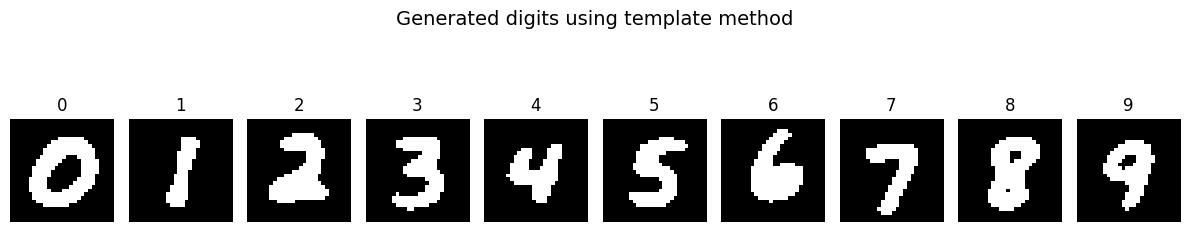


Generating using threshold method:


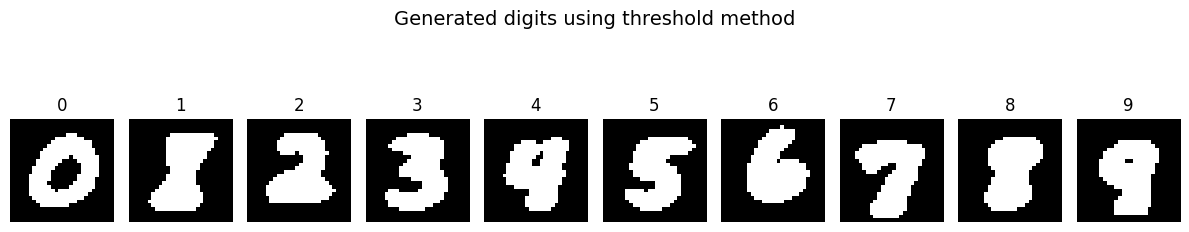


Generating using probabilistic method:


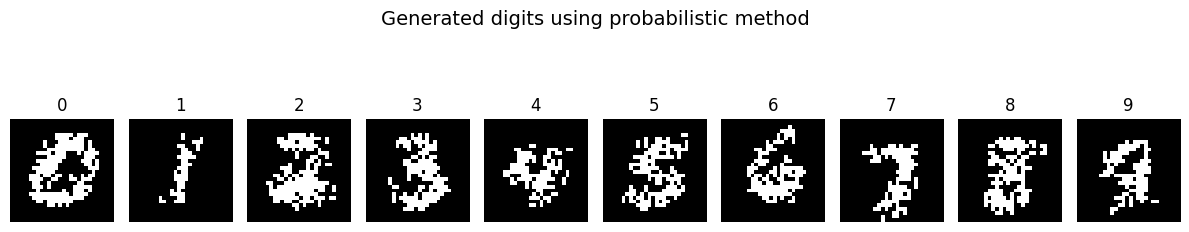

In [73]:
def interactive_generation():
    """Interactive function to generate digits with custom parameters"""
    print("Interactive Digit Generation")
    print("===========================")
    
    # Generate samples for all digits with different methods
    methods = ['template', 'threshold', 'probabilistic']
    
    for method in methods:
        print(f"\nGenerating using {method} method:")
        plt.figure(figsize=(12, 3))
        
        for digit in range(10):
            plt.subplot(1, 10, digit + 1)
            if method == 'probabilistic':
                gen_img = generate_digit(digit, method=method, temperature=1.2)
            else:
                gen_img = generate_digit(digit, method=method)
            plt.imshow(gen_img, cmap='gray')
            plt.title(f'{digit}', fontsize=12)
            plt.axis('off')
        
        plt.suptitle(f'Generated digits using {method} method', fontsize=14)
        plt.tight_layout()
        plt.show()

# Run interactive generation
interactive_generation()